<a href="_index.ipynb">&larr; FIL </a>&loz;
<a href="../../README.md"> &uarr; TOC &uarr; </a>
<img src='../_img/icon.svg' align='right' width='10%'></img>
# Filterung eines binär übertragenen Bitstroms
 
Es soll ein Bitstrom binär im Tiefpassbereich übertragen werden mit $a = \pm 1$. Dem Bitstrom wird weißes Rauschen überlagert (Added White Gaussian Noise, AWGN), danach wird er mit einem harten Entscheider dekodiert. 

Es werden die Bitfehler und die Bitfehlerrate (Bit Error Rate, BER) simuliert mit ohne Filterung durch verschiedene Filter mit linearem und nicht-linearem Phasengang.

In [8]:
import os, sys
module_path = os.path.abspath(os.path.join('..')) # append directory one level up to import path
if module_path not in sys.path:  # ... if it hasn't been appended already
    sys.path.append(module_path)
import dsp_fpga_lib as dsp # import and set plot properties

import numpy as np
from numpy.fft import fft
import scipy.signal as sig
from scipy.special import erfc

# %matplotlib widget
# "%matplotlib widget" enables interactive widgets but requires the modules ipympl and ipywidgets
# if needed, install them from a console with 'pip install ipympl ipywidgets'
# or, from within this jupyter notebook with '%pip install ipympl ipywidgets'
import matplotlib.pyplot as plt
plt.style.use('../script.mplstyle')
figsize = {"figsize":(13,9)}

In [9]:
SNR_dB      = 1 # dB
SNR         = 10 ** (SNR_dB/10.0)  # linear SNR
OSR         = 8 # Samples per symbol 
                # -> F_max = 1 / (2 * OSR)
OSR_2       = 4 # OSR/2, middle of symbol

R_DB = 0.5  # ripple of passband
R_SB = 60   # ripple of stopband
del_DB = (10**(R_DB/20)-1) / (10**(R_DB/20)+1) # lin. Ripple
del_SB = 10**(-R_SB/20.0) # lin. ripple
F_DB = 0.08  # corner of passband
F_SB = 0.12 # corner of stopband
#L = 32 # manual filter order
N_plt       = 3000 # Number of plotted samples
N_show      = 1000  # Number of displayed samples

Pe = 0.5 * erfc(np.sqrt(SNR)) # theoretical error probability
                           # for BPSK
VEC_SIZE = max(np.ceil(100/Pe),10000) # minimum vector length f(Pe)
                        # for estimating the SNR

In [10]:
#====== Filter ================================
#
b = np.ones(4); a = 1 # MA filter
# Parks-McClellan / Remez (= Linphase FIR) - Filter:
L, bands, amps, w = dsp.remezord([F_DB, F_SB],[1, 0], [del_DB, del_SB])
#b = sig.remez(L, [0, F_DB, F_SB, 0.5], [1, 0], [1, 1], Hz = 1)
b = sig.remez(L, bands, amps, w)

# IIR-Filter
[b, a] = sig.iirdesign(F_DB*2, F_SB*2, R_DB, R_SB, ftype='ellip')
#[b, a] = sig.iirdesign(F_DB*2, F_SB*2, R_DB, R_SB, ftype='cheby2')
#[b, a] = sig.iirdesign(F_DB*2, F_SB*2, R_DB, R_SB, ftype='butter')
#b = [0.2]; a = [1, -0.8]
#

In [11]:
#================================================
w, H = sig.freqz(b,a,2048)
Hmax = max(np.abs(H)); H = H / Hmax
tau, w = dsp.grpdelay(b,a, 2048)
f = w / (2* np.pi)
delay = tau[int(np.floor(2048 / (2*OSR)))] # delay at F = 0.5 / (2 * OSR)
dN = int(np.floor(delay))
print('Group delay @ F= %2.3e = %.1f T_S' %((0.5 / (2 * OSR)), delay))
#====== Symbol & Noise Generation ===============
# random binary (+/-1) symbol sequence
s = 2 * np.random.randint(0,high=2,size=VEC_SIZE)-1
s = s.repeat(OSR) # repeat each symbol OSR times 
# linear power of the noise; average signal power = 1:
No = 1.0/SNR
# random signal with normal distribution and power No
n = np.sqrt(No/2)*np.random.randn(VEC_SIZE*OSR) # 
# signal + noise
x = s + n
#x = s
xf = sig.lfilter(b,a,x) / Hmax
# decode received signal + noise in the middle of symbol
y = np.sign(x[OSR_2::OSR]) # use every OSR-th sample
yf = np.sign(xf[OSR_2+dN::OSR]) # 
# find erroneous symbols in unfiltered signal
err = [y != s[OSR_2::OSR]]
err_pos = (np.array(np.where(y != s[OSR_2::OSR])) * OSR) + OSR_2
error_sum = np.sum(err)
BER = error_sum / VEC_SIZE
# and in filtered signal
err_pos_f = (np.array(np.where(yf != s[OSR_2:-dN:OSR])) * OSR) + OSR_2
err_f = [yf != s[OSR_2:-dN:OSR]]
error_sum_f = np.sum(err_f)
BER_f = error_sum_f / VEC_SIZE
print('SNR (dB) = %4.2f => Theor. BER = %8.3e\n\
=> Sim. Länge = %d  erforderlich.\n' %(SNR_dB, Pe, VEC_SIZE))
print('Dekodierung mit gestörtem Signal:')
print('Fehler = %6d => BER = %8.3e\n' %(error_sum, BER))
print('Dekodierung nach TP-Filterung:')      
print('Fehler = %6d => BER = %8.3e' % (error_sum_f, BER_f))
n = np.arange(N_plt)

Group delay @ F= 3.125e-02 = 9.1 T_S
SNR (dB) = 1.00 => Theor. BER = 5.628e-02
=> Sim. Länge = 10000  erforderlich.

Dekodierung mit gestörtem Signal:
Fehler =    606 => BER = 6.060e-02

Dekodierung nach TP-Filterung:
Fehler =    100 => BER = 1.000e-02


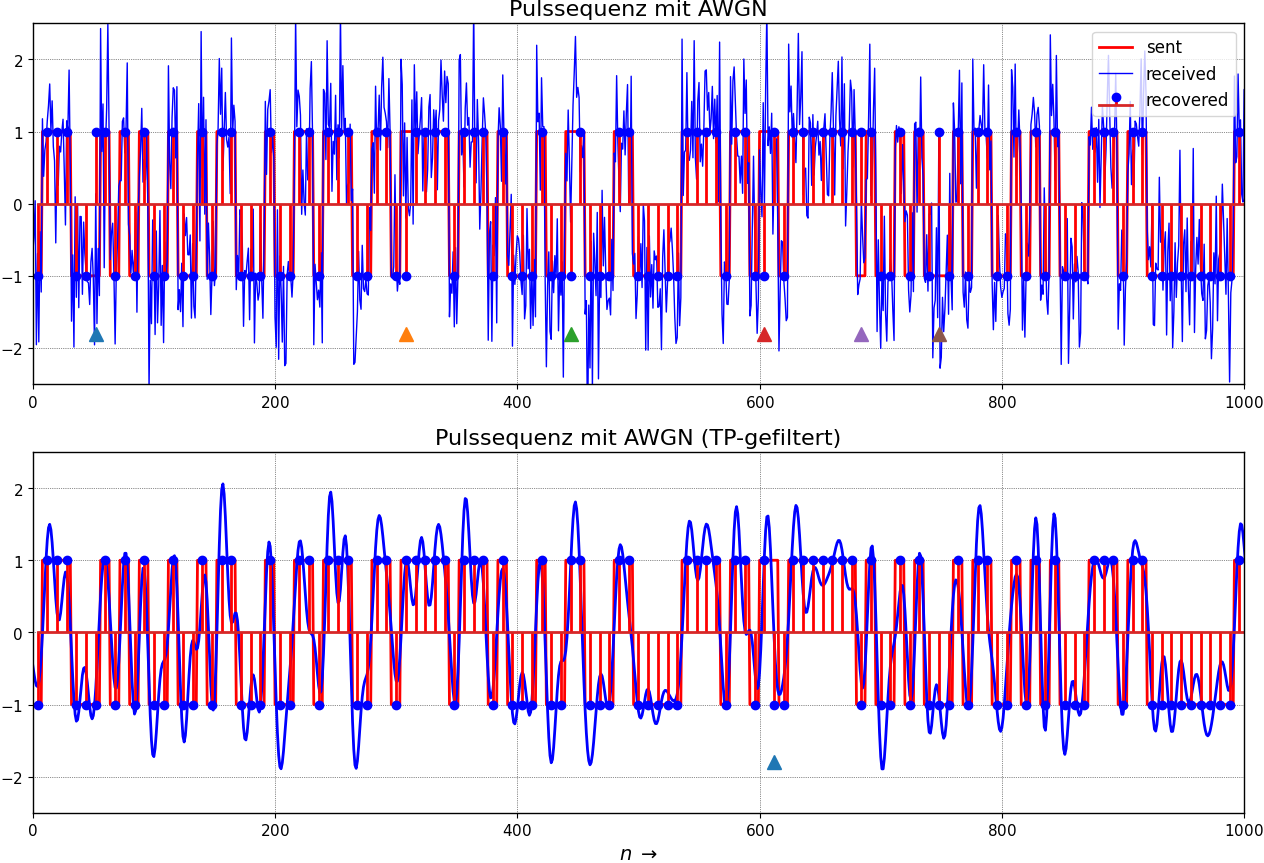

In [12]:
fig1, (ax1,ax2) = plt.subplots(2, **figsize)
ax1.set_title(u'Pulssequenz mit AWGN')
ax1.set_ylim(-2.5,2.5);  ax1.set_xlim(0, N_show)
ax1.plot(n, s[0:N_plt], 'r', label = 'sent') 
ax1.plot(n, x[0:N_plt], 'b', lw = 1, label = 'received')
ax1.stem(n[OSR_2::OSR],y[0:np.ceil(N_plt/OSR).astype(int)],
         linefmt='r', markerfmt = 'bo', label = 'recovered')
if np.shape(err_pos)[1] > 0:
    ax1.plot(err_pos, np.ones(len(err_pos))*(-1.8), '^', markersize = 10)
ax1.legend()
#
ax2.set_title(u'Pulssequenz mit AWGN (TP-gefiltert)')
ax2.set_ylim(-2.5,2.5); ax2.set_xlim(0, N_show)
ax2.plot(n,s[0:N_plt], 'r', n, xf[dN:N_plt+dN], 'b')
ax2.stem(n[OSR_2::OSR],yf[0:int(np.ceil(N_plt/OSR))], linefmt='r', markerfmt='bo')
if (np.shape(err_pos_f)[1] > 0) and (np.shape(err_pos_f)[1] < 1000) :
    ax2.plot(err_pos_f, np.ones(len(err_pos_f))*(-1.8), '^', markersize = 10)
ax2.set_xlabel(r'$n \; \rightarrow$')
fig1.set_tight_layout(True)
plt.show()

C:\Users\Christian\AppData\Local\Temp\ipykernel_8476\3666341047.py:2: RuntimeWarning: divide by zero encountered in log10
  S = 20*np.log10(abs(fft(s,4096))); S = S - max(S)


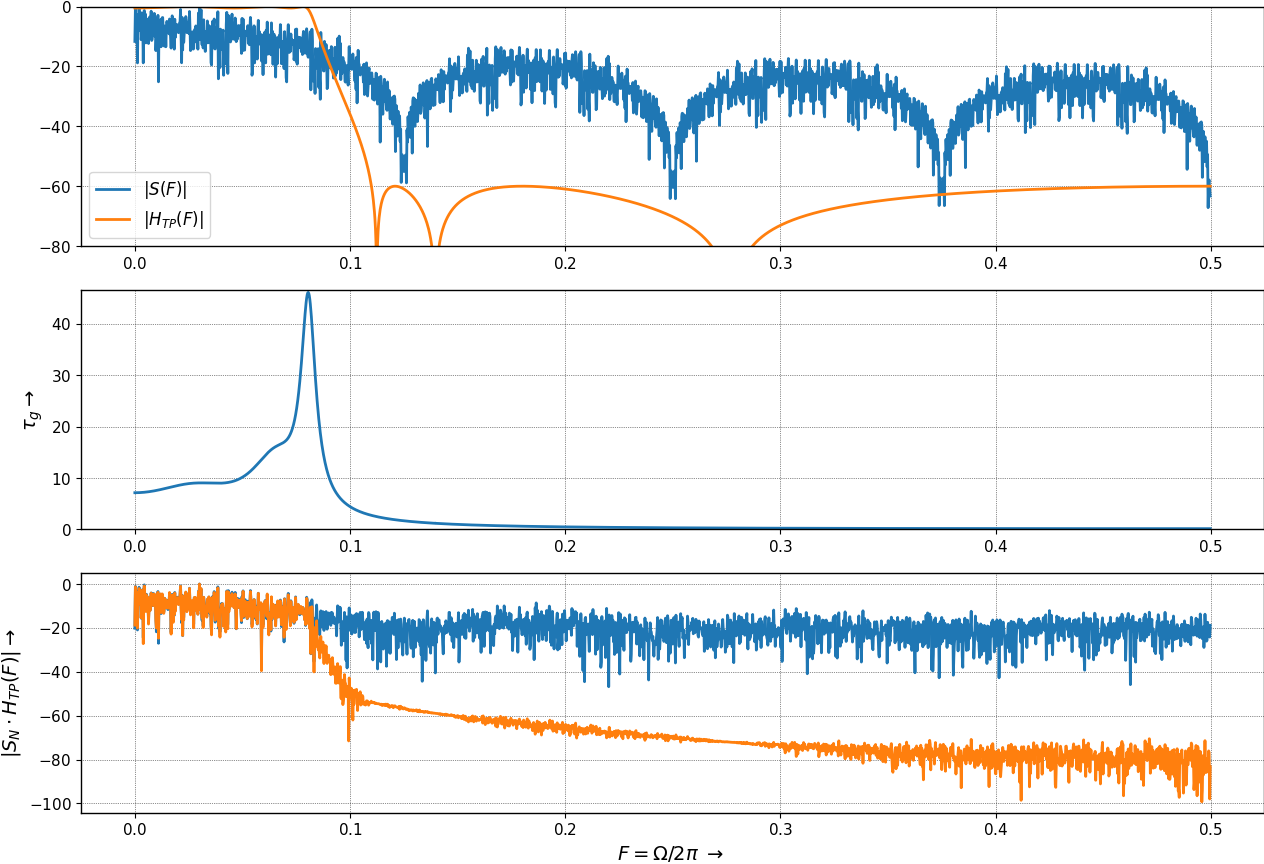

In [13]:
fig2, (ax1,ax2,ax3) = plt.subplots(3, **figsize)
S = 20*np.log10(abs(fft(s,4096))); S = S - max(S)
X = 20*np.log10(abs(fft(x,4096))); X = X - max(X)
Xf = 20*np.log10(abs(fft(xf,4096))); Xf = Xf - max(Xf)
#
ax1.grid(True)
ax1.plot(f, S[0:2048], label = r'$|S(F)|$')
ax1.plot(f, 20*np.log10(abs(H)), lw=2, label = r'$|H_{TP}(F)|$')
ax1.legend()
#
#ylabel(r'$|S(F)| \rightarrow $')
#ylabel(r'$|H_TP(F)| \rightarrow$')
ax1.set_ylim(-80, 0)
#
ax2.grid(True)
ax2.plot(f, tau)
ax2.set_ylabel(r'$\tau_g  \rightarrow$')
ax2.set_ylim(max(min(tau)-0.5,0), (max(tau) + 0.5))
#
ax3.grid(True)
ax3.plot(f, X[0:2048])
ax3.set_ylabel(r'$|S_N(F)| \rightarrow$')

ax3.plot(f, Xf[0:2048])
ax3.set_ylabel(r'$|S_N \cdot H_{TP}(F)| \rightarrow$')
ax3.set_xlabel(r'$F = \Omega / 2\pi \; \rightarrow$ ')
fig2.set_tight_layout(True)
plt.show()

### Experimente und Fragen

- Experimentieren Sie mit den unterschiedlichen Filterentwürfen, wie unterscheiden sich FIR und IIR Filter?
- Welchen Einfluss hat die Grenzfrequenz des eingesetzten Filters auf die Fehlerrate?

***
### Copyright

(c) 2016 - 2021 Prof. Dr. Christian Münker 

This jupyter notebook is part of a collection of notebooks on various topics of Digital Signal Processing. The latest version can be found at https://github.com/chipmuenk/dsp.

This notebook is provided as [Open Educational Resource](https://en.wikipedia.org/wiki/Open_educational_resources). Feel free to use it for your own purposes. The text is licensed under [Creative Commons Attribution 4.0](https://creativecommons.org/licenses/by/4.0/), the code of the IPython examples under the [MIT license](https://opensource.org/licenses/MIT). Please attribute the work as follows: *Christian Münker, Digital Signal Processing - Vorlesungsunterlagen mit Simulationsbeispielen, 2021*.